In [85]:
import os
os.environ['KERAS_BACKEND'] = 'theano' 

import gzip

import pandas as pd

import numpy as np
np.random.seed(1000)

from matplotlib import pyplot as plt
import seaborn as sns
plt.tight_layout()
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('colorblind', 8)))
dims = (11.7, 8.27)
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import time
import math
import random

from keras.utils import np_utils
from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, SpatialDropout2D, MaxPooling3D, SeparableConv2D

In [158]:
def load_mnist(path, kind='train'):
    ## Load MNIST function. Retrieved from https://github.com/zalandoresearch/fashion-mnist
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

def preprocess(train, test):
    sc = StandardScaler()
    sc.fit(train)

    xform_train = sc.transform(train)
    xform_test = sc.transform(test)
    
    return xform_train, xform_test

def refresh_data():
    X_train, y_train = load_mnist('C:/git/IST718/Lab3/data/fashion', kind='train')
    X_test, y_test = load_mnist('C:/git/IST718/Lab3/data/fashion', kind='t10k')

    ## Transforming the data
    X_train, X_test = preprocess(X_train.astype('float64'), X_test.astype('float64'))

    ## Shaping the data from a 2 dimensional array to 3
    X_train = np.reshape(X_train, (60000, 28, 28))
    X_test = np.reshape(X_test, (10000, 28, 28))
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

    ## Assigning the categories to the Y data
    Y_train = np_utils.to_categorical(y_train, 10)
    Y_test = np_utils.to_categorical(y_test, 10)
    
    ## Translating the X data to float32 and reducing to a decimal value
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    return X_train, X_test, Y_train, Y_test

def refresh_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, strides=3, activation='relu', padding='same', input_shape=(1,28,28)))
    model.add(Conv2D(filters=64, kernel_size=3, strides=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

def int_to_desc(i):
    ## Numeric dict for each value in the dataset
    conv = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',
            6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    ## Try to get the value for key i, else assign unknown
    try:
        ret = conv[i]
    except:
        ret = 'Unknown'
    return ret

def check_random(n, x, y, p):
    ## Takes in integer N, X data, Y data, and predicted Y data and returns a plot with the information displayed
    rows = math.ceil(n/5)
    fig, ax = plt.subplots(nrows=rows, ncols=5, sharex=True, sharey=True,)
    ax = ax.flatten()
    for i in range(n):
        j = random.randint(0,len(p)-1)
        img = x[j].reshape(28, 28)
        if p[j] != y[j]:
            cmap = 'Reds'
        else:
            cmap = 'Greens'
        ax[i].imshow(img, cmap=cmap, interpolation='nearest')
        predicted = int_to_desc(p[j])
        actual = int_to_desc(y[j])
        ax[i].set_title('P: {}\n A: {}'.format(predicted,actual))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [4]:
losses = ['categorical_crossentropy', 'mean_squared_error', 'kullback_leibler_divergence', 'categorical_hinge']
optimizers = ['adam', 'adadelta', 'sgd', 'rmsprop']
metrics = ['categorical_accuracy']
epochs = 25
batchsize = 128

result_columns = ['loss_func', 'optimizer', 'epochs', 'batchsize', 'acc', 'val_acc', 'loss', 'val_loss', 'time', 'total_acc', 'total_loss']
result_df = pd.DataFrame(columns=result_columns)

In [5]:
for opt_func in optimizers:
    for loss_func in losses:
        print('Refreshing data...')
        X_train, X_test, Y_train, Y_test = refresh_data()
        
        print('Refreshing model...')
        model = refresh_model()
        
        print('Running {0} optimizer with {1} loss function.'.format(opt_func, loss_func))
        
        ## Starting timer
        starttime = time.time()
        
        ## Compiling and fitting model
        model.compile(loss=loss_func, optimizer=opt_func, metrics=metrics)
        fit = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), batch_size=batchsize, epochs=epochs, verbose=0)
        
        ## Ending timer
        endtime = time.time()
        
        ## Total time
        totaltime = endtime - starttime
        
        ## Evaluating model on test data
        score = model.evaluate(X_test, Y_test, verbose=0)
        
        rownum = len(result_df)
        result_df.at[rownum, 'loss_func'] = loss_func
        result_df.at[rownum, 'optimizer'] = opt_func
        result_df.at[rownum, 'epochs'] = epochs
        result_df.at[rownum, 'batchsize'] = batchsize
        result_df.at[rownum, 'acc'] = fit.history['categorical_accuracy']
        result_df.at[rownum, 'val_acc'] = fit.history['val_categorical_accuracy']
        result_df.at[rownum, 'loss'] = fit.history['loss']
        result_df.at[rownum, 'val_loss'] = fit.history['val_loss']
        result_df.at[rownum, 'time'] = totaltime
        result_df.at[rownum, 'total_loss'] = score[0]
        result_df.at[rownum, 'total_acc'] = score[1]


Refreshing data...
Refreshing model...
Running adam optimizer with categorical_crossentropy loss function.
Refreshing data...
Refreshing model...
Running adam optimizer with mean_squared_error loss function.
Refreshing data...
Refreshing model...
Running adam optimizer with kullback_leibler_divergence loss function.
Refreshing data...
Refreshing model...
Running adam optimizer with categorical_hinge loss function.
Refreshing data...
Refreshing model...
Running adadelta optimizer with categorical_crossentropy loss function.
Refreshing data...
Refreshing model...
Running adadelta optimizer with mean_squared_error loss function.
Refreshing data...
Refreshing model...
Running adadelta optimizer with kullback_leibler_divergence loss function.
Refreshing data...
Refreshing model...
Running adadelta optimizer with categorical_hinge loss function.
Refreshing data...
Refreshing model...
Running sgd optimizer with categorical_crossentropy loss function.
Refreshing data...
Refreshing model...
Run

In [12]:
print('Refreshing data...')
X_train, X_test, Y_train, Y_test = refresh_data()

print('Refreshing model...')
model = refresh_model()

## Starting timer
starttime = time.time()

## Compiling and fitting model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
fit = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), batch_size=128, epochs=50, verbose=1)
        
## Ending timer
endtime = time.time()

## Total time
totaltime = endtime - starttime



Refreshing data...
Refreshing model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 138us/step - loss: 1.1902 - categorical_accuracy: 0.5570 - val_loss: 0.7536 - val_categorical_accuracy: 0.7127
Epoch 2/50
60000/60000 [==============================] - 8s 138us/step - loss: 0.7772 - categorical_accuracy: 0.7083 - val_loss: 0.6600 - val_categorical_accuracy: 0.7466
Epoch 3/50
60000/60000 [==============================] - 8s 137us/step - loss: 0.6876 - categorical_accuracy: 0.7456 - val_loss: 0.6152 - val_categorical_accuracy: 0.7691
Epoch 4/50
60000/60000 [==============================] - 8s 136us/step - loss: 0.6217 - categorical_accuracy: 0.7726 - val_loss: 0.5469 - val_categorical_accuracy: 0.7923
Epoch 5/50
60000/60000 [==============================] - 8s 139us/step - loss: 0.5802 - categorical_accuracy: 0.7907 - val_loss: 0.5220 - val_categorical_accuracy: 0.8046
Epoch 6/50
60000/60000 [===========================

Epoch 48/50
60000/60000 [==============================] - 8s 141us/step - loss: 0.3568 - categorical_accuracy: 0.8743 - val_loss: 0.3567 - val_categorical_accuracy: 0.8753
Epoch 49/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.3524 - categorical_accuracy: 0.8753 - val_loss: 0.3505 - val_categorical_accuracy: 0.8792
Epoch 50/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.3547 - categorical_accuracy: 0.8759 - val_loss: 0.3523 - val_categorical_accuracy: 0.8783


In [71]:
## Predicting Values and flattening them back into a single int
pred = model.predict(X_test)
pred_flat = [argmax(x) for x in pred]

## Flattening the Y_Test values
ytest_flat = [argmax(x) for x in Y_test]

In [72]:
## Evaluating model on test data
score = model.evaluate(X_test, Y_test, verbose=0)

print(score)
print(totaltime)

[0.35232463648319245, 0.8783]
423.1124060153961


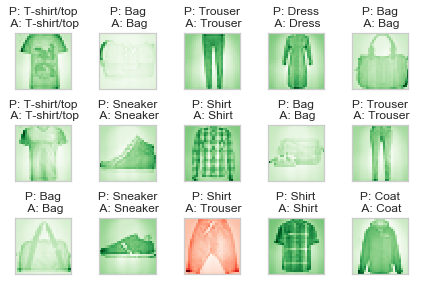

In [160]:
check_random(n=15, x=X_test, y=ytest_flat, p=pred_flat)

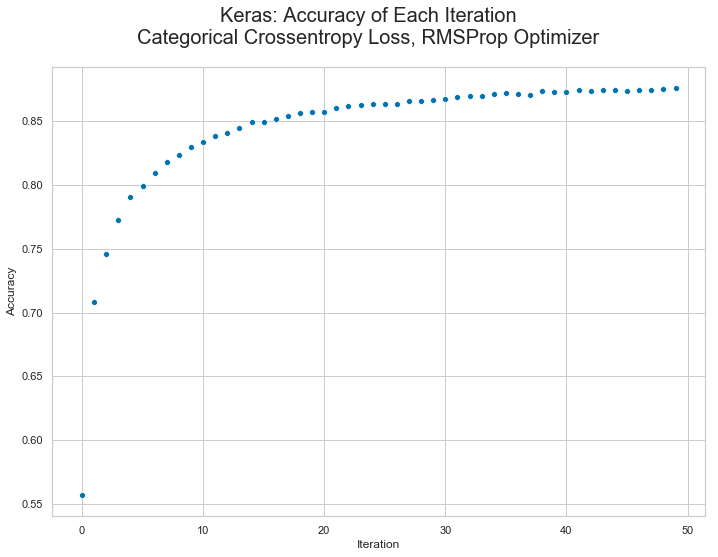

In [155]:
## Graphing the differences between K values, weight methods, and the algorithm used
fig1, ax1 = plt.subplots(figsize=dims)
plot1 = sns.scatterplot(x=range(0,50), y=fit.history['categorical_accuracy'], ax=ax1)
plot1 = fig1.suptitle('Keras: Accuracy of Each Iteration\nCategorical Crossentropy Loss, RMSProp Optimizer', fontsize=20)
plot1 = ax1.set_ylabel('Accuracy')
plot1 = ax1.set_xlabel('Iteration')
#plot1.get_figure().savefig('Keras_best_run.png')

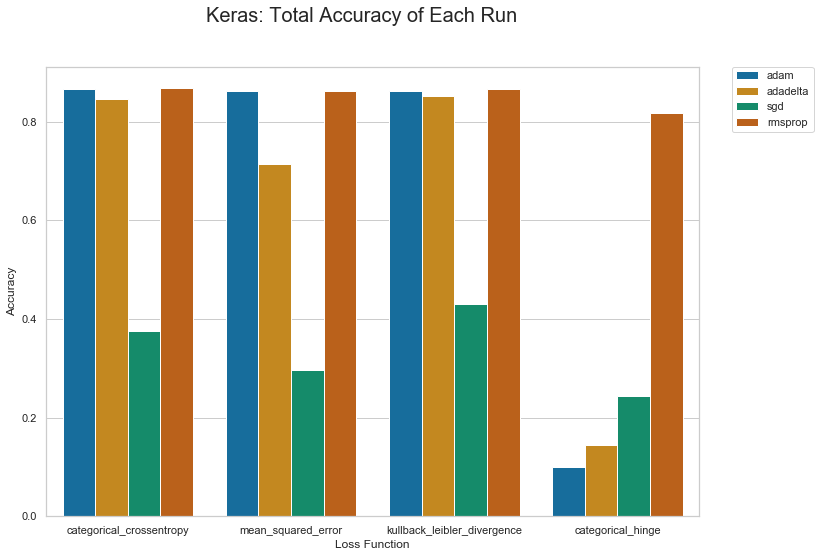

In [120]:
fig2, ax2 = plt.subplots(figsize=dims)
plot2 = sns.barplot(x='loss_func', y='total_acc', hue='optimizer', data=result_df[['loss_func', 'optimizer', 'total_acc']])
plot2 = fig2.suptitle('Keras: Total Accuracy of Each Run', fontsize=20)
plot2 = ax2.set_ylabel('Accuracy')
plot2 = ax2.set_xlabel('Loss Function')
plot2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plot2.get_figure().savefig('Keras_all_runs.png')